In [1]:
#pip install finance-datareader

In [2]:
#pip install plotly

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

import torch
import torch.nn as nn

In [4]:
#목적: 데이터의 변동성 관계없이(ex) 액면분할, 추종을 따라 가고자 함

In [5]:
data = fdr.DataReader("005930")
data = data[["Close"]] #기억하기! [] 하나만 하면 시리즈로 나오고, [[]] 해야 데이터프레임 객체로 반납됨. 시리즈는 메소드가 너무 작아.. 

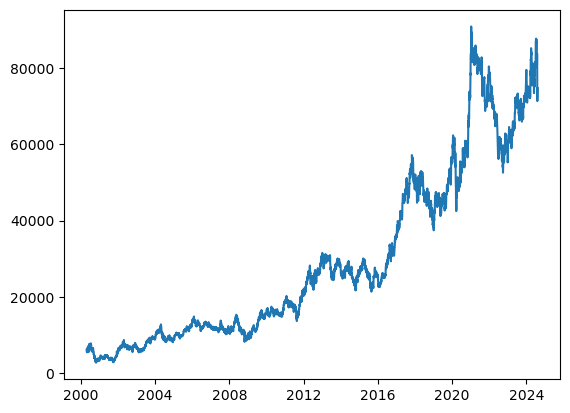

In [6]:
plt.plot(data)

### 딥러닝 전용 코드 작성

* aim: Close 의 '추세'를 반영해서 Close 값 예측

In [26]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [27]:
#추세를 추종하도록, LSTM 돌리기 전 데이터에 순차적 특성을 만들어 주기 위하여 하는 과정

from copy import deepcopy as dc
#복사 도와주는 객체

#참고: shift(), resample()... 등 순차적 데이터 다루는 메소드 
#데이터에 추세성. 시간적 계열성. 그걸 추종하기 위한 데이터로 만들어주기 위해서 shift()와 같은 함수로 순차를 부여한다는 개념.
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    for i in range(1, n_steps+1):
        df[f"Close(t-{i})"] = df["Close"].shift(i)
        #df['Close(t-1)'] = df['Close'].shift(1)
        #df['Close(t-2)'] = df['Close'].shift(2)
        #df['Close(t-3)'] = df['Close'].shift(3)...
    df.dropna(inplace=True)
    return df

lookback=7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2000-05-03,6180,6280.0,6000.0,5400.0,5600.0,5640.0,5800.0,6050.0
2000-05-04,6180,6180.0,6280.0,6000.0,5400.0,5600.0,5640.0,5800.0
2000-05-08,6560,6180.0,6180.0,6280.0,6000.0,5400.0,5600.0,5640.0
2000-05-09,6370,6560.0,6180.0,6180.0,6280.0,6000.0,5400.0,5600.0
2000-05-10,6350,6370.0,6560.0,6180.0,6180.0,6280.0,6000.0,5400.0
...,...,...,...,...,...,...,...,...
2024-08-05,71400,79600.0,83100.0,83900.0,81000.0,81200.0,80900.0,80400.0
2024-08-06,72500,71400.0,79600.0,83100.0,83900.0,81000.0,81200.0,80900.0
2024-08-07,74700,72500.0,71400.0,79600.0,83100.0,83900.0,81000.0,81200.0


In [8]:
#넘파이 객체로 바꿔주고 shape 확인.
shifted_df_as_np=shifted_df.to_numpy()
shifted_df_as_np.shape

(5993, 8)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1)) #구간 주면서 이안에 구겨넣도록함
shifted_df_as_np=scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[-0.92183075, -0.91956497, -0.92590914, ..., -0.93406593,
        -0.93044069, -0.92477625],
       [-0.92183075, -0.92183075, -0.91956497, ..., -0.93497224,
        -0.93406593, -0.93044069],
       [-0.9132208 , -0.92183075, -0.92183075, ..., -0.9395038 ,
        -0.93497224, -0.93406593],
       ...,
       [ 0.6306786 ,  0.58083154,  0.55590801, ...,  0.83912994,
         0.77342245,  0.777954  ],
       [ 0.60122352,  0.6306786 ,  0.58083154, ...,  0.82100374,
         0.83912994,  0.77342245],
       [ 0.63294438,  0.60122352,  0.6306786 , ...,  0.7417016 ,
         0.82100374,  0.83912994]])

In [10]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

#X는 과거 n_steps개의 값. 즉 입력 데이터
#y는 내가 예측하고자 하는 정답값이라서 y. 타깃 데이터
print(X.shape, y.shape)

(5993, 7) (5993,)


In [11]:
X[0]

array([-0.91956497, -0.92590914, -0.9395038 , -0.93497224, -0.93406593,
       -0.93044069, -0.92477625])

In [12]:
X = dc(np.flip(X, axis=1))
X

array([[-0.92477625, -0.93044069, -0.93406593, ..., -0.9395038 ,
        -0.92590914, -0.91956497],
       [-0.93044069, -0.93406593, -0.93497224, ..., -0.92590914,
        -0.91956497, -0.92183075],
       [-0.93406593, -0.93497224, -0.9395038 , ..., -0.91956497,
        -0.92183075, -0.92183075],
       ...,
       [ 0.777954  ,  0.77342245,  0.83912994, ...,  0.7417016 ,
         0.55590801,  0.58083154],
       [ 0.77342245,  0.83912994,  0.82100374, ...,  0.55590801,
         0.58083154,  0.6306786 ],
       [ 0.83912994,  0.82100374,  0.7417016 , ...,  0.58083154,
         0.6306786 ,  0.60122352]])

In [13]:
split_index = int(len(X)*0.95)
split_index

5693

### Train and Test

In [28]:
X_train=X[:split_index] #X의 처음부터 splitidx 앞까지.
X_test=X[split_index:] #splitidx 부터 끝까지.
y_train=y[:split_index]
y_test=y[split_index:]
#하지만 이대로 넣을순없어. (,) 의 튜플이 나오는데 LSTM에 넣으려면 세개(, , )여야 하잔아 SO 다시 변형

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))


y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

#shape을 정확하게 만들어야함. 만들고 찍어보세요
#y는 검증데이터잖아 그래서 1차원 튜플로! 

In [29]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5693, 7, 1) (300, 7, 1) (5693, 1) (300, 1)


In [30]:
# tensor로 변경, float 변경 

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

In [31]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([5693, 7, 1]) torch.Size([300, 7, 1]) torch.Size([5693, 1]) torch.Size([300, 1])


In [32]:
from torch.utils.data import Dataset

class TimeSeriesDataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)  # X의 길이를 반환합니다.

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset= TimeSeriesDataset(X_test, y_test)

In [33]:
from torch.utils.data import DataLoader

batch_size=16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [34]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0], batch[1]
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [35]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM (input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
        
model = LSTM(1,4,1)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [36]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [38]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [39]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.544
Batch 200, Loss: 0.109
Batch 300, Loss: 0.025

Val Loss: 0.037
***************************************************

Epoch: 2
Batch 100, Loss: 0.006
Batch 200, Loss: 0.005
Batch 300, Loss: 0.004

Val Loss: 0.018
***************************************************

Epoch: 3
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003
Batch 300, Loss: 0.002

Val Loss: 0.007
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.003
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.001
Batch 300, Loss: 0.000

Val Loss: 0.002
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.002
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.002
*****************

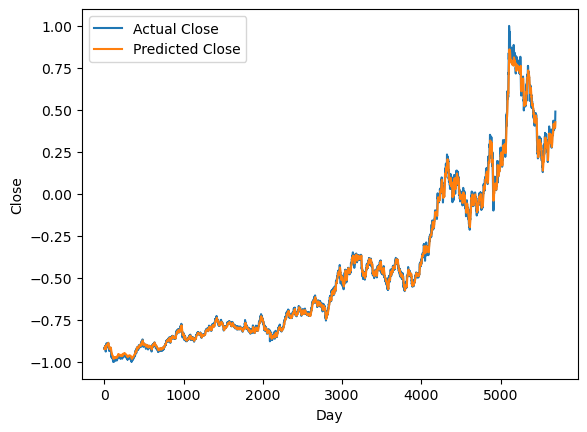

In [40]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

#아놔 과대적합.